In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import scipy.sparse as sp
import yaml
import time
import gget
from scipy.stats import zscore

import anndata as an
import scanpy as sc
import rapids_singlecell as rsc
import scvi

import cupy as cp
from cuml.manifold import TSNE
from cuml.decomposition import PCA

sc.settings.verbosity = 2

# Load in data

In [2]:
%%time
fpath = "/scratch/indikar_root/indikar1/shared_data/hematokytos/new_processed/fib_ihsc_processed.h5ad"
adata = sc.read_h5ad(fpath)
adata.X = adata.layers['log_norm'].copy()
adata

CPU times: user 427 ms, sys: 1.42 s, total: 1.85 s
Wall time: 1min 40s


AnnData object with n_obs × n_vars = 15317 × 23434
    obs: 'batch', 'barcoded_phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'leiden', 'cluster_str', 'cluster'
    var: 'gene_id', 'gene_type', 'Chromosome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable_rank', 'variances', 'variances_norm'
    uns: 'batch_colors', 'cluster_colors', 'dr

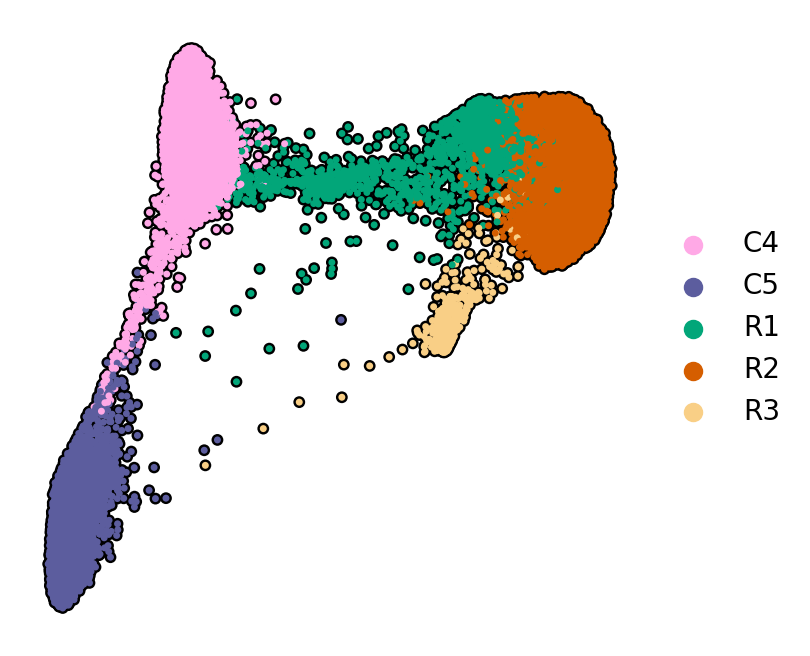

In [3]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sc.pl.draw_graph(
    adata,
    color=['cluster'],
    size=25,
    ncols=1,
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
    alpha=1,
    title='',
    # legend_loc='none',
)

In [7]:
print(adata.obs.groupby('batch', observed=True)['cluster'].value_counts(sort=False))

batch  cluster
fib    C4         3262
       C5         3694
       R1            4
       R2            0
       R3            0
hsc    C4         1350
       C5          158
       R1         1982
       R2         4343
       R3          524
Name: count, dtype: int64


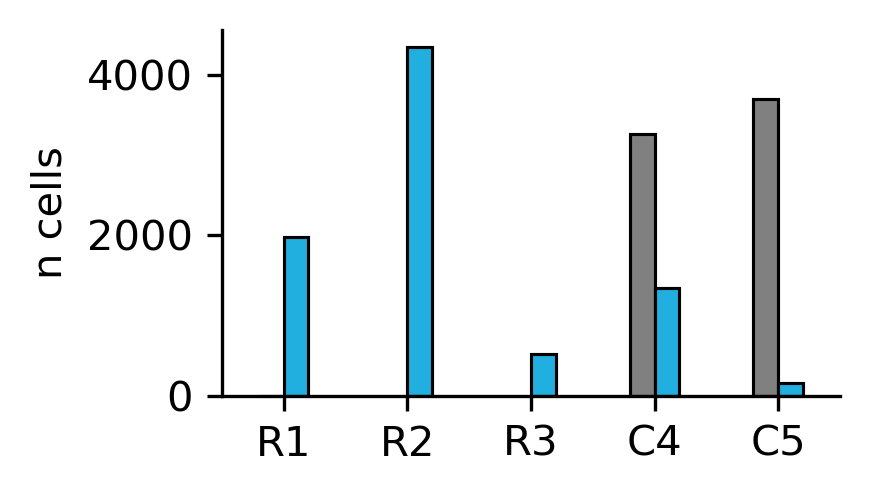

In [30]:
cluster_counts = adata.obs.groupby(['cluster', 'batch'], observed=True).size().reset_index(name='n cells')
cluster_counts

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 1.75

batch_colors = {
    'fib': 'Grey',
    'hsc': 'deepskyblue',
}

sns.barplot(
    data=cluster_counts,
    x='cluster',
    y='n cells',
    hue='batch',
    order=['R1', 'R2', 'R3', 'C4', 'C5'],
    hue_order=['fib', 'hsc'],
    palette=['Grey', 'deepskyblue'],
    legend=False,
    width=0.4,
    ec='k',
    lw=0.75,
)

plt.xlabel('')

sns.despine()
plt.tight_layout()
plt.show()

In [9]:
# remove spike-in controls
adata.obs['cluster_clean'] = adata.obs['cluster'].copy()

# identify hsc cells in control clusters
mask = (adata.obs['batch'] == 'hsc') & (adata.obs['cluster'].isin(['C4', 'C5']))
# label them as NaN
adata.obs.loc[mask, 'cluster_clean'] = np.nan

adata.obs['cluster_clean'] = adata.obs['cluster_clean'].astype('category')

print(adata.obs['cluster_clean'].value_counts(sort=False))
adata.obs.groupby('batch')['cluster_clean'].value_counts(sort=False)

cluster_clean
C4    3262
C5    3694
R1    1986
R2    4343
R3     524
Name: count, dtype: int64


/tmp/ipykernel_819019/312978435.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('batch')['cluster_clean'].value_counts(sort=False)


batch  cluster_clean
fib    C4               3262
       C5               3694
       R1                  4
       R2                  0
       R3                  0
hsc    C4                  0
       C5                  0
       R1               1982
       R2               4343
       R3                524
Name: count, dtype: int64

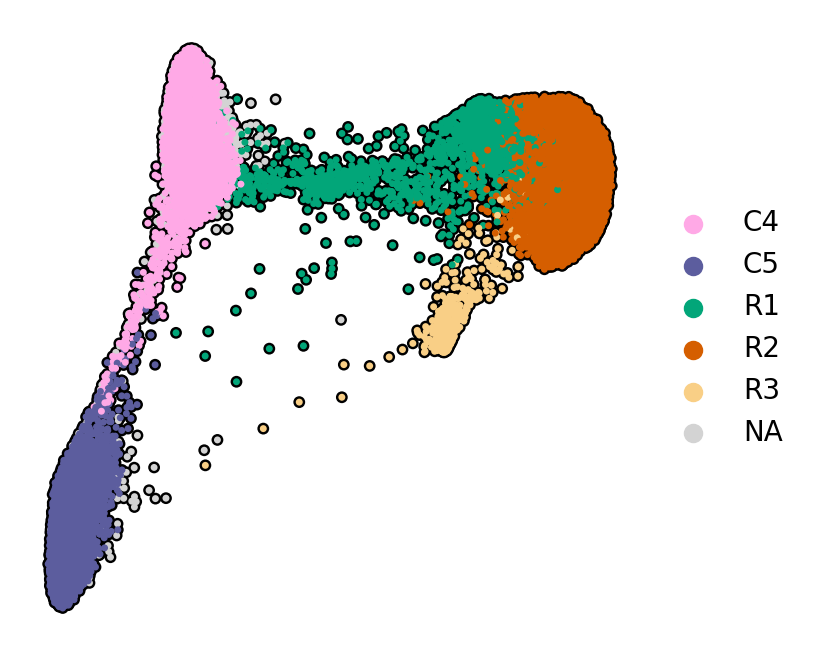

In [10]:
adata.uns['cluster_clean_colors'] = adata.uns['cluster_colors'].copy()

sc.pl.draw_graph(
    adata,
    color=['cluster_clean'],
    size=25,
    ncols=1,
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
    alpha=1,
    title='',
    # legend_loc='none',
)

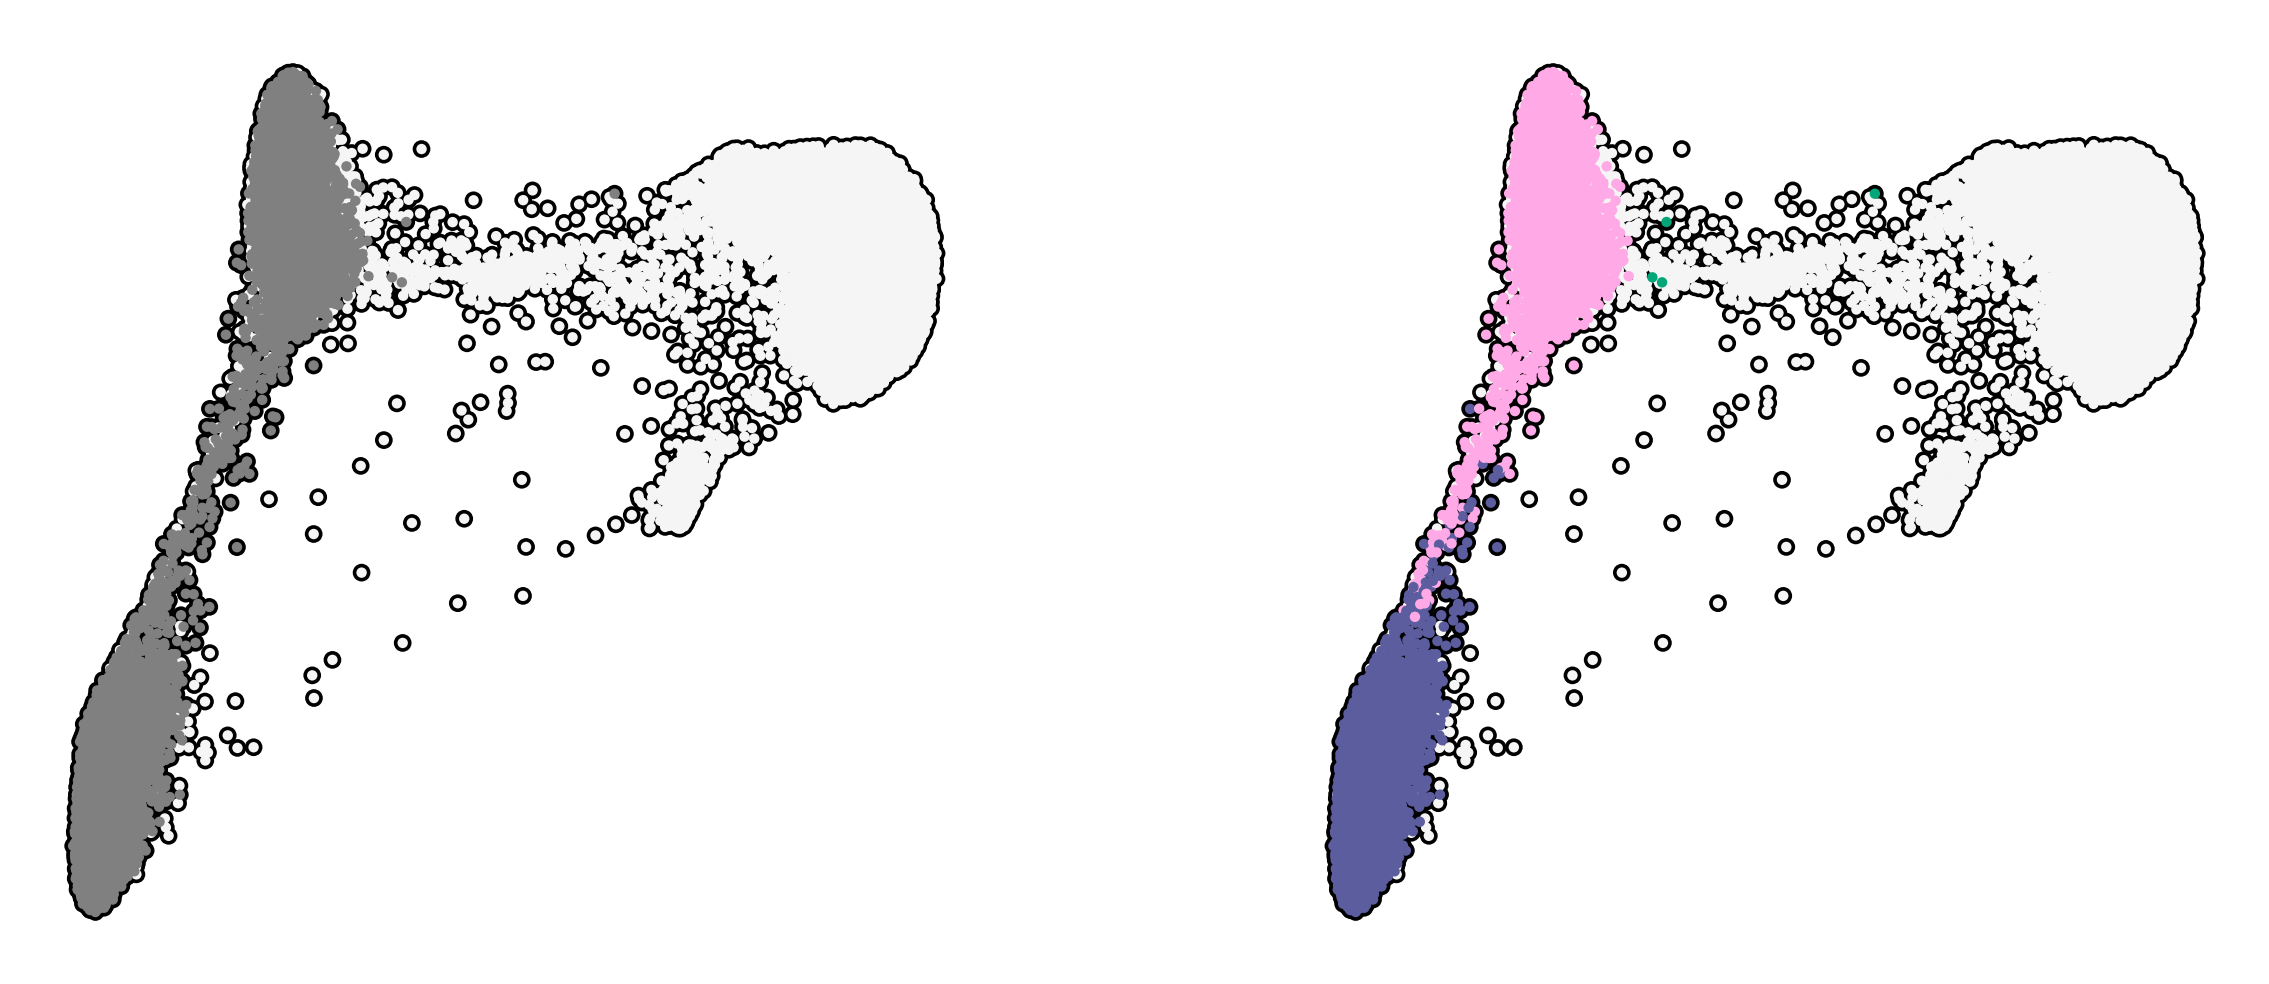

In [14]:
batches = adata.obs['batch'].cat.categories

batch_colors = {
    'fib': 'Grey',
    'hsc': 'deepskyblue',
}

adata.uns['batch_colors'] = [batch_colors[c] for c in batches]

mask = adata.obs['batch'] == 'fib'

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

sc.pl.draw_graph(
    adata,
    color=['batch', 'cluster'],
    mask_obs=mask,
    size=25,
    ncols=2,
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
    legend_loc='none',
    alpha=1,
    na_color='whitesmoke',
    title=['', ''],
)

# DGE

In [31]:
def get_significant_DEGs(df, alpha=0.05, logfc_thresh=0.5, pct_nz_thresh=0.0):
    
    tmp = df.copy()
    
    print(f"Filtering for significant DEGs (adjusted p-value < {alpha}, logfoldchange > {logfc_thresh})...")

    tmp['abs_lfc'] = tmp['logfoldchanges'].apply('abs')
    tmp = tmp[(tmp['abs_lfc'] > logfc_thresh) & (tmp['pvals_adj'] < alpha)]

    if pct_nz_thresh != 0.0:
        if 'pct_nz_reference' in tmp.columns:
            # make sure either group of interest OR reference has % cells expressing above threshold
            tmp = tmp[(tmp['pct_nz_group'] > pct_nz_thresh) | (tmp['pct_nz_reference'] > pct_nz_thresh)]
            print(f"Removed genes expressed in less than {pct_nz_thresh*100}% of group OR reference cells.")
        
        else:
            # Only apply pct_nz_group filter to upregulated genes
            upregulated_mask = tmp['logfoldchanges'] > 0
            keep_mask = (~upregulated_mask) | (tmp['pct_nz_group'] > pct_nz_thresh)
            tmp = tmp[keep_mask]

            tmp = tmp[tmp['pct_nz_group'] > pct_nz_thresh]
            print(f"Removed upregaulted genes expressed in less than {pct_nz_thresh*100}% of cells. Kept all downregulated genes.")
    
    print(f"N unique significant DEGs: {tmp['names'].nunique()}\n")
    
    return tmp

In [43]:
# sc.tl.rank_genes_groups(
#     adata, 
#     groupby='cluster_clean',
#     method='wilcoxon',
#     layer='log_norm',
#     use_raw=False,
#     pts=True,
#     key_added='cluster_deg',
# )

sc.tl.rank_genes_groups(
    adata, 
    groupby='cluster',
    method='wilcoxon',
    layer='log_norm',
    use_raw=False,
    pts=True,
    key_added='cluster_deg_wspike',
)

# deg = sc.get.rank_genes_groups_df(
#     adata, 
#     group=None,
#     key='cluster_deg',
#     pval_cutoff=0.05,
# )

# # sig = get_significant_DEGs(deg, logfc_thresh=0.5)
# print(deg.shape)
# print(f"N unique DEGs: {deg['names'].nunique()}")
# deg.head()

ranking genes
    finished (0:00:27)


In [71]:
deg = sc.get.rank_genes_groups_df(
    adata, 
    group=None,
    key='cluster_deg',
    # key='cluster_deg',
    pval_cutoff=0.05,
)
print(f"Initial n genes: {deg['names'].nunique()}")

# gene info
gtf = adata.var[['gene_type']].copy()
gtf = gtf.reset_index(names='names')
print(gtf.shape)


# merge with gtf file
deg = pd.merge(deg, gtf, how='left', on='names')
print(f"After merging w GTF: {deg['names'].nunique()}")

# remove ENSG and MT- and ribo genes
deg = deg[~deg['names'].str.startswith(('ENSG', 'MT-', 'RP'))]

# filter for protein-coding
deg = deg[deg['gene_type'] == 'protein_coding']

print(f"Protein-coding n genes: {deg['names'].nunique()}")
deg.head()

Initial n genes: 12367
(23434, 2)
After merging w GTF: 12367
Protein-coding n genes: 10596


,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference,gene_type
0,C4,TSPAN9,76.823090,1.737851,0.0,0.0,1.000000,0.986147,protein_coding
5,C4,IFITM1,68.229347,2.646459,0.0,0.0,1.000000,0.889755,protein_coding
6,C4,IFITM3,68.225212,1.493457,0.0,0.0,1.000000,0.996682,protein_coding
7,C4,IFIT2,67.914444,3.575133,0.0,0.0,0.918455,0.277478,protein_coding
8,C4,IFI16,66.300896,2.644392,0.0,0.0,0.998467,0.527665,protein_coding


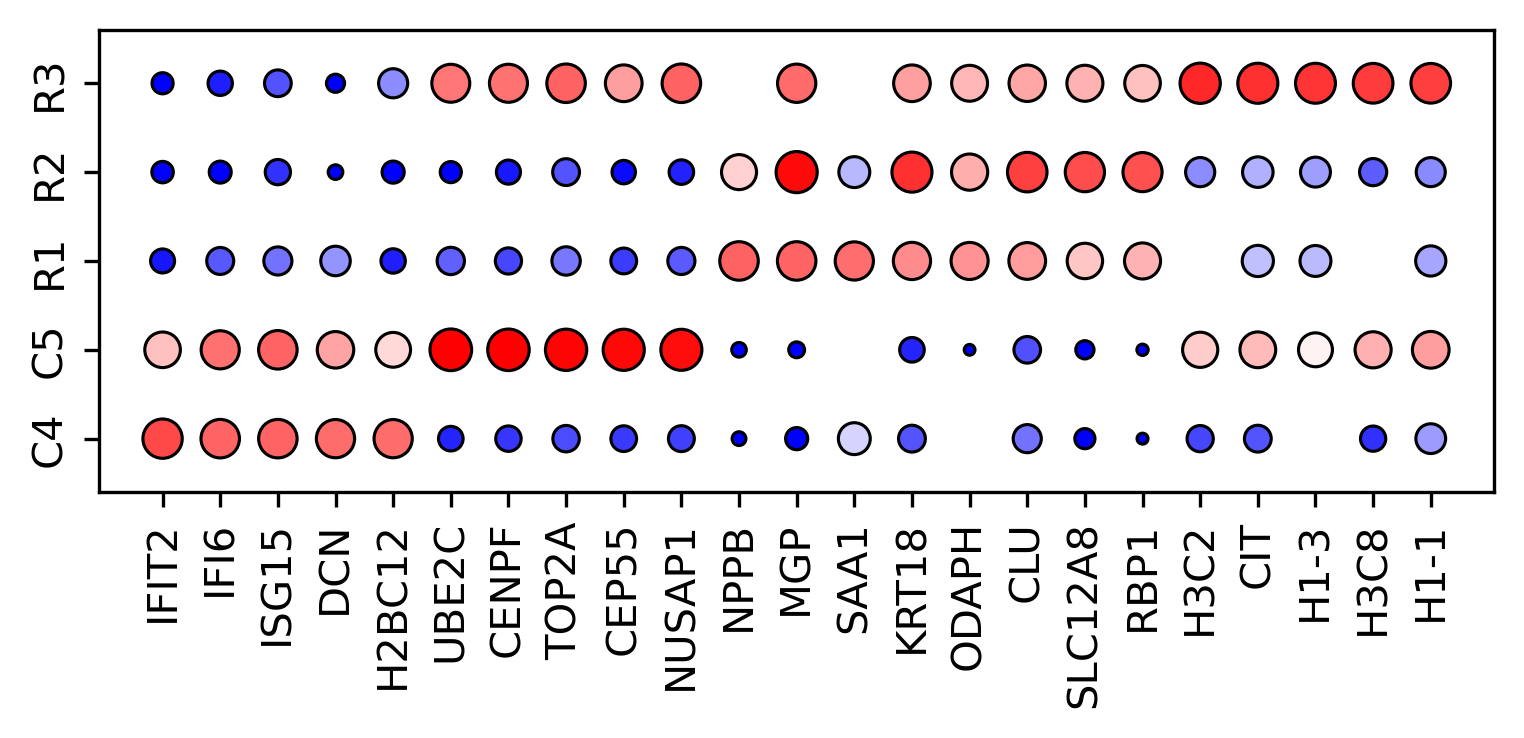

In [72]:
top_n_genes = 5
pct_nz_group = 0.1

# groups = ['C1', 'C2', 'C3', 'C4', 'C5']
groups = ['C4', 'C5', 'R1', 'R2', 'R3']#, 'C4', 'C5']
groups.reverse()

# filter out genes only expressed in a few cells, robust DEG
gdf = deg[deg['pct_nz_group'] > pct_nz_group].copy()

# sort by logfc and select top de genes per group
gdf = gdf.sort_values(by=['group', 'logfoldchanges'], ascending=[True, False])
gdf = gdf.groupby('group').head(top_n_genes)

deg_genes = gdf['names'].unique()

# now filter the full frame for these genes
plot_df = deg[deg['names'].isin(deg_genes)].copy()

plot_df['label'] = plot_df['group'].apply(lambda x: x.replace("_", " "))
plot_df = plot_df.sort_values(by=['group', 'logfoldchanges'], ascending=[True, False])

plot_df['names'] = pd.Categorical(plot_df['names'], categories=deg_genes, ordered=True)
plot_df['label'] = pd.Categorical(plot_df['label'], categories=groups, ordered=True)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 2

sns.scatterplot(
    data=plot_df,
    x='names',
    y='label',
    hue='logfoldchanges',
    size='logfoldchanges',
    sizes=(0, 100),
    ec='k',
    lw=0.75,
    hue_norm=(-5, 5),
    legend=False,
    palette='bwr',
)

plt.margins(y=0.15)
plt.ylabel("")
plt.xlabel("")

ax = plt.gca()
y_labels = ax.get_yticklabels()
y_ticks = ax.get_yticks()
ax.tick_params(axis='x', rotation=90)
ax.set_yticks(y_ticks, y_labels, rotation=90, va='center')

plt.show()

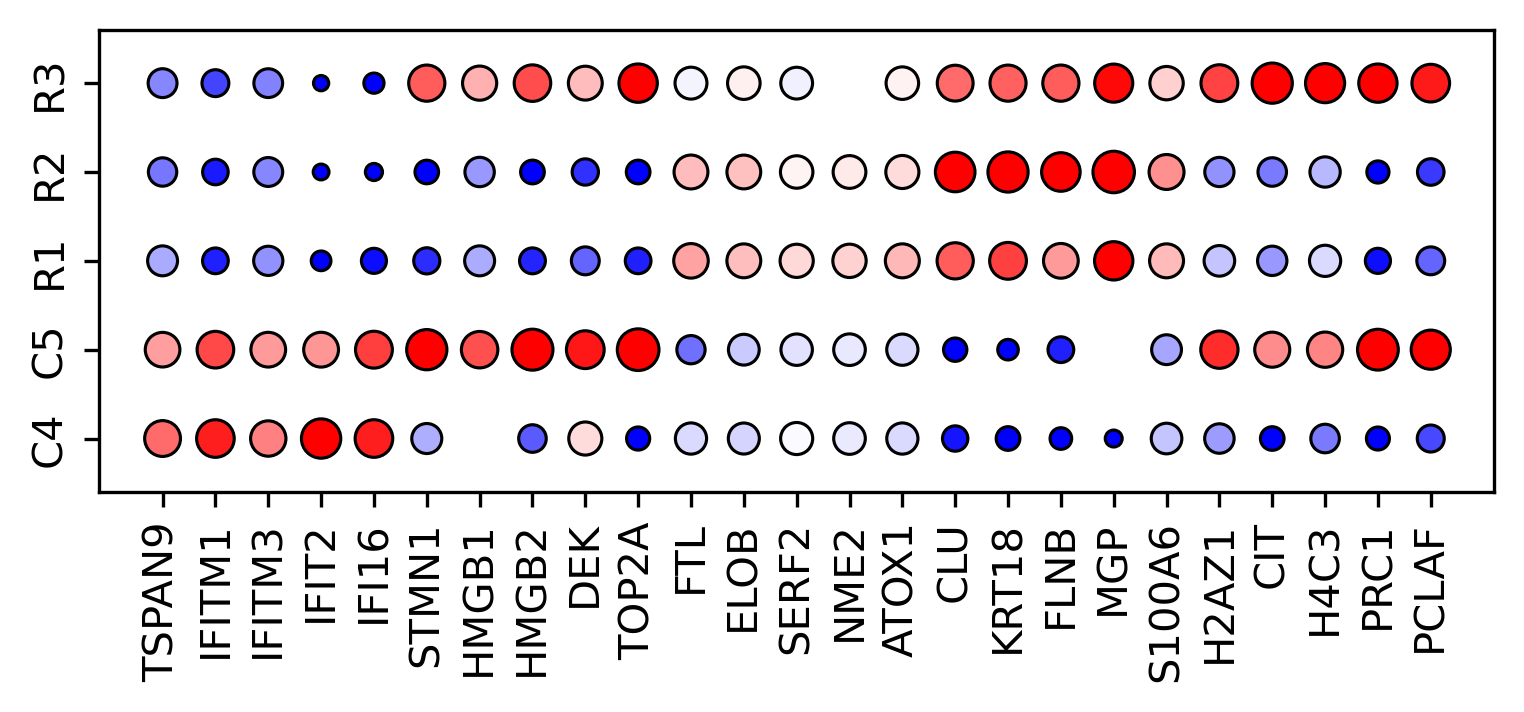

In [73]:
# sorted by SCORES
top_n_genes = 5
pct_nz_group = 0.1

# groups = ['C1', 'C2', 'C3', 'C4', 'C5']
# groups.reverse()

# filter out genes only expressed in a few cells, robust DEG
gdf = deg[deg['pct_nz_group'] > pct_nz_group].copy()

# sort by logfc and select top de genes per group
gdf = gdf.sort_values(by=['group', 'scores'], ascending=[True, False])
gdf = gdf.groupby('group').head(top_n_genes)

deg_genes = gdf['names'].unique()

# now filter the full frame for these genes
pdf = deg[deg['names'].isin(deg_genes)].copy()

pdf['label'] = pdf['group'].apply(lambda x: x.replace("_", " "))
pdf = pdf.sort_values(by=['group', 'logfoldchanges'], ascending=[True, False])

pdf['names'] = pd.Categorical(pdf['names'], categories=deg_genes, ordered=True)
pdf['label'] = pd.Categorical(pdf['label'], categories=groups, ordered=True)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 2

sns.scatterplot(
    data=pdf,
    x='names',
    y='label',
    hue='logfoldchanges',
    size='logfoldchanges',
    sizes=(0, 100),
    ec='k',
    lw=0.75,
    hue_norm=(-3, 3),
    legend=False,
    palette='bwr',
)

plt.margins(y=0.15)
plt.ylabel("")
plt.xlabel("")

ax = plt.gca()
y_labels = ax.get_yticklabels()
y_ticks = ax.get_yticks()
ax.tick_params(axis='x', rotation=90)
ax.set_yticks(y_ticks, y_labels, rotation=90, va='center')

plt.show()

In [81]:
pd.set_option('display.max_colwidth', None)

# database = 'celltypes'
# database = 'Tabula_Sapiens'
database = "GO_Biological_Process_2025"
# database="KEGG_2021_Human"
# database='MSigDB_Hallmark_2020' 
# database="Reactome_Pathways_2024"
# database = "CellMarker_2024"

n_query = 200

direction = 'up'
sort_col = 'scores'

groups = ['R1', 'R2', 'R3', 'C4', 'C5',]

for group in groups:
    print(f"{group}:")
    tmp = deg[deg['group'] == group]
    
    if direction == 'up':
        tmp = tmp[tmp['logfoldchanges'] > 0]
        tmp = tmp.sort_values(by=sort_col, ascending=False) 
    else:
        tmp = tmp[tmp['logfoldchanges'] > 0]
        tmp = tmp.sort_values(by=sort_col, ascending=True)
        
    gene_list = tmp['names'].head(n_query).unique()

    edf = gget.enrichr(
        gene_list,
        database=database,
        save=False,
    )
    
    if database == 'CellMarker_2024':
        edf = edf[~edf['path_name'].str.endswith('Mouse')]
    
    display(edf[['path_name', 'overlapping_genes', 'adj_p_val']].head(15))
    print("=" * 100 + "\n")

14:34:50 - INFO - Performing Enrichr analysis using database GO_Biological_Process_2025.
2025-12-09 14:34:50 | [INFO] Performing Enrichr analysis using database GO_Biological_Process_2025.


R1:


,path_name,overlapping_genes,adj_p_val
0,Cellular Respiration (GO:0045333),"[COX7B, NDUFA13, NDUFA4, NDUFA3, NDUFA2, NDUFB2, NDUFA1, NDUFB1, UQCR11, ETFB, UQCR10, COX6C, COX7C, UQCRH, NDUFS6, UQCRQ, NDUFS5]",1.123454e-14
1,Aerobic Electron Transport Chain (GO:0019646),"[COX7B, NDUFA4, NDUFA3, NDUFA2, NDUFB2, NDUFA1, NDUFB1, UQCR11, UQCR10, COX6C, COX7C, UQCRH, NDUFS6, UQCRQ, NDUFS5]",3.332135e-14
2,Mitochondrial ATP Synthesis Coupled Electron Transport (GO:0042775),"[COX7B, NDUFA4, NDUFA3, NDUFA2, NDUFB2, NDUFA1, NDUFB1, UQCR11, UQCR10, COX6C, COX7C, UQCRH, NDUFS6, UQCRQ, NDUFS5]",3.332135e-14
3,Proton Motive Force-Driven ATP Synthesis (GO:0015986),"[ATP5PF, NDUFA13, NDUFA3, NDUFA2, NDUFB2, NDUFA1, NDUFB1, ATP5F1E, ATP5MC1, NDUFS6, NDUFS5, ATP5MK, ATP5MG, ATP5ME]",1.798371e-13
4,Oxidative Phosphorylation (GO:0006119),"[ATP5PF, NDUFA13, NDUFA3, NDUFA2, NDUFB2, NDUFA1, NDUFB1, UQCRH, ATP5F1E, NDUFS6, NDUFS5, ATP5MG, ATP5ME]",5.871651e-12
5,Proton Motive Force-Driven Mitochondrial ATP Synthesis (GO:0042776),"[ATP5PF, NDUFA13, NDUFS6, NDUFS5, NDUFA3, NDUFA2, NDUFB2, NDUFA1, NDUFB1, ATP5MG, ATP5F1E, ATP5ME]",2.209522e-11
6,Energy Derivation by Oxidation of Organic Compounds (GO:0015980),"[COX7B, NDUFA4, UQCRQ, UQCR11, UQCR10, COX6C, COX7C, UQCRH]",9.224166e-07
7,"Mitochondrial Electron Transport, NADH to Ubiquinone (GO:0006120)","[NDUFA4, NDUFS6, NDUFA3, NDUFS5, NDUFA2, NDUFB2, NDUFB1]",6.120014e-06
8,ATP Biosynthetic Process (GO:0006754),"[ATP5PF, ATP5MK, ATP5MG, ATP5F1E, ATP5MC1, ATP5ME]",1.487359e-05
9,Aerobic Respiration (GO:0009060),"[NDUFA13, NDUFS6, NDUFS5, NDUFA3, NDUFA2, NDUFB2, NDUFA1, NDUFB1, UQCRH]",1.487359e-05


14:34:51 - INFO - Performing Enrichr analysis using database GO_Biological_Process_2025.
2025-12-09 14:34:51 | [INFO] Performing Enrichr analysis using database GO_Biological_Process_2025.



R2:


,path_name,overlapping_genes,adj_p_val
0,Cytoskeleton Organization (GO:0007010),"[ARHGAP10, FGD4, NCOA3, PACSIN2, SH3BGRL3, LARP4, PDZD8, SIPA1L3, SH3D19]",0.003732
1,Regulation of Cell Morphogenesis (GO:0022604),"[SPARC, EFNA5, LARP4, PDZD8, SH3D19]",0.005561
2,Clathrin Coat Assembly (GO:0048268),"[HIP1, NSG1, EPS15, GAS7]",0.005561
3,Actin Filament Organization (GO:0007015),"[ENAH, MYO1D, SVIL, DLG1, HIP1, GSN, NEBL, NCOA3, ARHGAP12]",0.010657
4,Negative Regulation of Peptidase Activity (GO:0010466),"[CSTB, SERPINE1, SPOCK1, SERPINB6]",0.020328
5,Positive Regulation of Cell-Substrate Adhesion (GO:0010811),"[DOCK5, CCDC80, JUP, NCOA3, FBLN2, S100A10]",0.020706
6,Positive Regulation of Cellular Component Organization (GO:0051130),"[ANXA2, AHNAK, FAF1, ASAP1, FNIP1, CLU, S100A10]",0.024932
7,Axon Guidance (GO:0007411),"[ENAH, NCOA3, UNC5C, PTPRJ, SLIT3, EFNA5, PTK2, MYPN]",0.025354
8,Regulation of Substrate Adhesion-Dependent Cell Spreading (GO:1900024),"[DOCK5, NCOA3, EFNA5, PTK2, S100A10]",0.025354
9,Regulation of Small GTPase Mediated Signal Transduction (GO:0051056),"[TIAM2, AKAP13, ARHGAP10, FGD4, DOCK9, ARHGEF3, CYRIB, ARHGAP12]",0.025354


14:34:51 - INFO - Performing Enrichr analysis using database GO_Biological_Process_2025.
2025-12-09 14:34:51 | [INFO] Performing Enrichr analysis using database GO_Biological_Process_2025.



R3:


,path_name,overlapping_genes,adj_p_val
0,Mitotic Sister Chromatid Segregation (GO:0000070),"[NCAPG2, KIF14, CDCA8, NCAPG, KIF11, SMC4, AURKB, KIF15, CCNB1, NUSAP1, CEP192, CEP55, DLGAP5, PLK1, KIF23, KNL1, NDC80, ZWINT, TPX2, CENPE, KIF18B, KIFC1, PRC1, CENPK, BIRC5, KIF2C, NCAPD2, NCAPD3, KPNB1, RAN]",9.750088e-31
1,Mitotic Spindle Organization (GO:0007052),"[GPSM2, PLK1, CDCA8, KIF23, KIF11, CKAP5, AURKB, NDC80, KIF15, AURKA, CENPE, TPX2, CCNB1, KIFC1, PRC1, KIF4A, NUF2, STMN1, BIRC5, CEP192, DLGAP5, KPNB1, RAN, SPC25]",3.541164e-25
2,Microtubule Cytoskeleton Organization Involved in Mitosis (GO:1902850),"[GPSM2, PLK1, KIF11, CKAP5, AURKB, NDC80, CENPE, CCNB1, KIF4A, NUF2, STMN1, NUSAP1, CDK1, TACC3, BIRC5, DLGAP5, KPNB1, RAN, SPC25]",1.612104e-21
3,Positive Regulation of Cell Cycle Process (GO:0090068),"[GPSM2, NCAPG2, KIF14, CDCA8, NCAPG, KIF23, KNL1, SMC4, NDC80, AURKB, AURKA, DBF4, RACGAP1, NUSAP1, BIRC5, NCAPD2, NCAPD3, KIF20B, ECT2, RAD18, MAD2L1]",4.974137e-18
4,Negative Regulation of Mitotic Metaphase/Anaphase Transition (GO:0045841),"[CDC20, CENPF, NUF2, PLK1, BUB1B, BIRC5, FBXO5, NDC80, ZWINT, SPC24, MAD2L1, SPC25]",7.523888e-15
5,Mitotic Nuclear Division (GO:0140014),"[UBE2C, NCAPG2, PLK1, KNL1, SMC4, NDC80, ZWINT, KIF18B, KIFC1, UBE2S, CENPK, NUSAP1, RAN]",9.169967e-14
6,Mitotic Spindle Assembly (GO:0090307),"[CDCA8, KIF23, KIF11, AURKB, KIF15, TPX2, RACGAP1, KIFC1, PRC1, KIF4A, BIRC5, CEP192, KPNB1]",9.169967e-14
7,Sister Chromatid Segregation (GO:0000819),"[TOP2A, KIF18B, KIFC1, NCAPG2, PLK1, CENPK, NUSAP1, KNL1, SMC4, NDC80, ZWINT, RAN]",9.169967e-14
8,Spindle Assembly Checkpoint Signaling (GO:0071173),"[CDC20, CENPF, NUF2, PLK1, BUB1B, BIRC5, NDC80, ZWINT, SPC24, MAD2L1, SPC25]",9.169967e-14
9,Mitotic Spindle Assembly Checkpoint Signaling (GO:0007094),"[CDC20, CENPF, NUF2, PLK1, BUB1B, BIRC5, NDC80, ZWINT, SPC24, MAD2L1, SPC25]",9.169967e-14


14:34:51 - INFO - Performing Enrichr analysis using database GO_Biological_Process_2025.
2025-12-09 14:34:51 | [INFO] Performing Enrichr analysis using database GO_Biological_Process_2025.



C4:


,path_name,overlapping_genes,adj_p_val
0,Defense Response to Virus (GO:0051607),"[IFITM3, IFITM1, IFITM2, IFI6, IFIT1, SAMHD1, IFIT3, IFI44L, IFIT2, IFIH1, IFI16, STAT1, STAT2, MX2, MX1, SMARCA5, EIF2AK2, ISG15, BST2, PLSCR1, IFI27, OAS1, OAS2, IRF1, OAS3, SHFL, RIGI]",9.423056e-20
1,Negative Regulation of Viral Process (GO:0048525),"[IFITM3, IFITM1, SP100, IFITM2, STAT1, MX1, EIF2AK2, ISG15, IFIT1, IFIH1, BST2, PLSCR1, OAS1, IFI16, OAS2, OAS3, SHFL]",6.878587e-17
2,Negative Regulation of Viral Genome Replication (GO:0045071),"[IFITM3, IFITM1, IFITM2, MX1, EIF2AK2, ISG15, IFIT1, IFIH1, BST2, PLSCR1, IFI16, OAS1, OAS2, OAS3, SHFL]",2.684481e-16
3,Response to Interferon-Beta (GO:0035456),"[IFITM3, BST2, IFITM1, PLSCR1, IFITM2, PNPT1, IFI16, OAS1, STAT1, IRF1, XAF1, SHFL]",1.341835e-14
4,Regulation of Viral Genome Replication (GO:0045069),"[IFITM3, IFITM1, IFITM2, MX1, EIF2AK2, ISG15, IFIT1, IFIH1, BST2, PLSCR1, OAS1, IFI16, OAS2, OAS3, SHFL]",3.380127e-14
5,Cellular Response to Type I Interferon (GO:0071357),"[IFITM3, IFITM1, SP100, IFITM2, IFI27, OAS1, STAT1, OAS2, STAT2, OAS3, IFIT1]",9.208295e-11
6,Response to Cytokine (GO:0034097),"[IFITM3, APP, IFITM1, SP100, IFITM2, STAT1, MX2, MX1, EIF2AK2, ISG15, BST2, NUB1, PLSCR1, XAF1, SHFL]",3.837849e-10
7,Interferon-Mediated Signaling Pathway (GO:0140888),"[IFITM3, IFITM1, SP100, IFITM2, IFI27, OAS1, OAS2, STAT1, IRF1, OAS3, STAT2]",1.294319e-09
8,Type I Interferon-Mediated Signaling Pathway (GO:0060337),"[IFITM3, IFITM1, SP100, IFITM2, IFI27, OAS1, STAT1, OAS2, STAT2, OAS3]",1.653878e-09
9,Response to Type II Interferon (GO:0034341),"[IFITM3, BST2, IFITM1, NUB1, SP100, IFITM2, STAT1, WNT5A, CCL2, GBP1, SHFL]",2.839504e-09


14:34:52 - INFO - Performing Enrichr analysis using database GO_Biological_Process_2025.
2025-12-09 14:34:52 | [INFO] Performing Enrichr analysis using database GO_Biological_Process_2025.



C5:


,path_name,overlapping_genes,adj_p_val
0,Mitotic Sister Chromatid Segregation (GO:0000070),"[KIF14, CDCA8, NCAPG, KIF23, KNL1, KIF11, SMC3, SMC1A, SMC4, NDC80, TPX2, CENPE, CCNB1, KIF18A, KIFC1, PRC1, CENPK, NUSAP1, BIRC5, KIF2C, SPDL1, CEP55, DLGAP5, RAN]",1.453316e-21
1,Mitotic Spindle Organization (GO:0007052),"[CDCA8, KIF23, TTK, KIF11, SMC3, SMC1A, NDC80, AURKA, CENPE, TPX2, CCNB1, CENPH, KIFC1, PRC1, KIF4A, NUF2, STMN1, BIRC5, DLGAP5, RAN, SPC25]",2.008438e-20
2,Microtubule Cytoskeleton Organization Involved in Mitosis (GO:1902850),"[TTK, KIF11, NDC80, CENPE, CCNB1, CENPH, KIF4A, NUF2, STMN1, NUSAP1, CDK1, TACC3, BIRC5, DLGAP5, RAN, SPC25]",1.717420e-16
3,Positive Regulation of Cell Cycle Process (GO:0090068),"[RANBP1, RRM1, KIF14, CDCA8, NCAPG, KIF23, KNL1, SMC4, NDC80, AURKA, PLSCR1, DBF4, RAD21, TPR, NUSAP1, BIRC5, KIF20B, ECT2, MAD2L1]",2.709979e-15
4,Negative Regulation of Mitotic Metaphase/Anaphase Transition (GO:0045841),"[CDC20, CENPF, NUF2, TPR, BIRC5, TTK, BUB3, FBXO5, BUB1, NDC80, MAD2L1, SPC25]",8.062224e-15
5,Spindle Assembly Checkpoint Signaling (GO:0071173),"[CDC20, CENPF, NUF2, TPR, BIRC5, TTK, BUB3, BUB1, NDC80, MAD2L1, SPC25]",1.351086e-13
6,Mitotic Spindle Assembly Checkpoint Signaling (GO:0007094),"[CDC20, CENPF, NUF2, TPR, BIRC5, TTK, BUB3, BUB1, NDC80, MAD2L1, SPC25]",1.351086e-13
7,Mitotic Spindle Checkpoint Signaling (GO:0071174),"[CDC20, CENPF, NUF2, TPR, BIRC5, TTK, BUB3, BUB1, NDC80, MAD2L1, SPC25]",1.351086e-13
8,Negative Regulation of Viral Process (GO:0048525),"[IFITM3, STAT1, MX1, EIF2AK2, ISG15, IFIT1, FAM111A, PLSCR1, IFI16, OAS2, OAS3, BANF1, PPIA]",1.212675e-11
9,Metaphase Chromosome Alignment (GO:0051310),"[CENPE, CCNB1, CENPF, KIF18A, KIFC1, GMNN, KIF14, CDCA8, KIF2C, SPDL1, CEP55, NDC80]",2.717480e-11


In [47]:
# get DEGs by broad grouping
# mapping = {
#     'C1': 'reprogramming',
#     'C2': 'reprogramming',
#     'C3': 'control',
#     'C4': 'control',
#     'C5': 'reprogramming',
# }

# adata.obs['group'] = adata.obs['cluster_str'].map(mapping)

mapping = {
    'R1': 'reprogramming',
    'R2': 'reprogramming',
    'R3': 'reprogramming',
    'C4': 'control',
    'C5': 'control',
}

# adata.obs['group'] = adata.obs['cluster_clean'].map(mapping)
adata.obs['group'] = adata.obs['cluster'].map(mapping) # with spike-in controls

sc.tl.rank_genes_groups(
    adata, 
    groupby='group',
    method='wilcoxon',
    layer='log_norm',
    use_raw=False,
    pts=True,
    key_added='broad_deg',
)

deg1 = sc.get.rank_genes_groups_df(
    adata, 
    group=None,
    key='broad_deg',
    pval_cutoff=0.05,
)
print(f"Initial n genes: {deg1['names'].nunique()}")

# merge with gtf file
deg1 = pd.merge(deg1, gtf, how='left', on='names')
print(f"After merging w GTF: {deg1['names'].nunique()}")

# remove ENSG and MT- genes
deg1 = deg1[~deg1['names'].str.startswith(('ENSG', 'MT-', 'RP'))]

# filter for protein-coding
deg1 = deg1[deg1['gene_type'] == 'protein_coding']

print(f"Protein-coding n genes: {deg1['names'].nunique()}")
deg1.head()

ranking genes


... storing 'group' as categorical


    finished (0:00:25)
Initial n genes: 11332
After merging w GTF: 11332
Protein-coding n genes: 9461


,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference,gene_type
0,control,IFI6,105.454208,5.835438,0.0,0.0,0.995983,0.451773,protein_coding
1,control,DCN,101.970818,5.651833,0.0,0.0,0.998228,0.167372,protein_coding
2,control,LY6E,101.798431,2.985550,0.0,0.0,0.995038,0.735152,protein_coding
3,control,IFI16,100.669479,5.134956,0.0,0.0,0.965501,0.211002,protein_coding
4,control,IFITM3,100.001633,1.923457,0.0,0.0,1.000000,0.994163,protein_coding


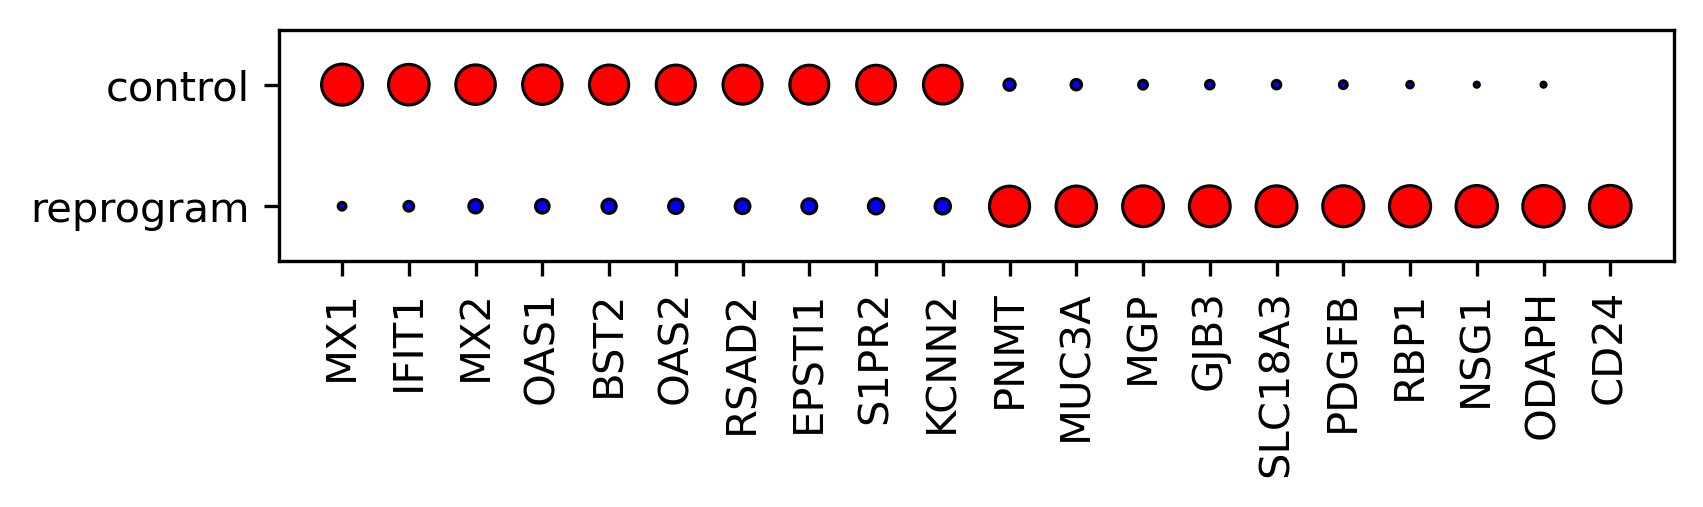

In [48]:
top_n_genes = 10
pct_nz_group = 0.1

gene_selection_col = 'logfoldchanges'

groups = ['reprogram', 'control']
groups.reverse()

# filter out genes only expressed in a few cells, robust DEG
gdf = deg1[deg1['pct_nz_group'] > pct_nz_group].copy()

# sort by logfc and select top de genes per group
gdf = gdf.sort_values(by=['group', gene_selection_col], ascending=[True, False])
gdf = gdf.groupby('group').head(top_n_genes)

deg_genes = gdf['names'].unique()

# now filter the full frame for these genes
pdf = deg1[deg1['names'].isin(deg_genes)].copy()

pdf['label'] = pdf['group'].map({
    "control" : "control",
    "reprogramming" : "reprogram",
})
pdf = pdf.sort_values(by=['group', 'logfoldchanges'], ascending=[True, False])
gene_order = pdf['names'].unique()

pdf['names'] = pd.Categorical(pdf['names'], categories=gene_order, ordered=True)
pdf['label'] = pd.Categorical(pdf['label'], categories=groups, ordered=True)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 1

sns.scatterplot(
    data=pdf,
    x='names',
    y='label',
    hue='logfoldchanges',
    size='logfoldchanges',
    sizes=(0, 100),
    ec='k',
    lw=0.75,
    hue_norm=(-5, 5),
    legend=False,
    palette='bwr',
)

plt.margins(y=0.45)
plt.ylabel("")
plt.xlabel("")

ax = plt.gca()
y_labels = ax.get_yticklabels()
y_ticks = ax.get_yticks()
ax.tick_params(axis='x', rotation=90)
ax.set_yticks(y_ticks, y_labels)#, rotation=90, va='center')

plt.show()

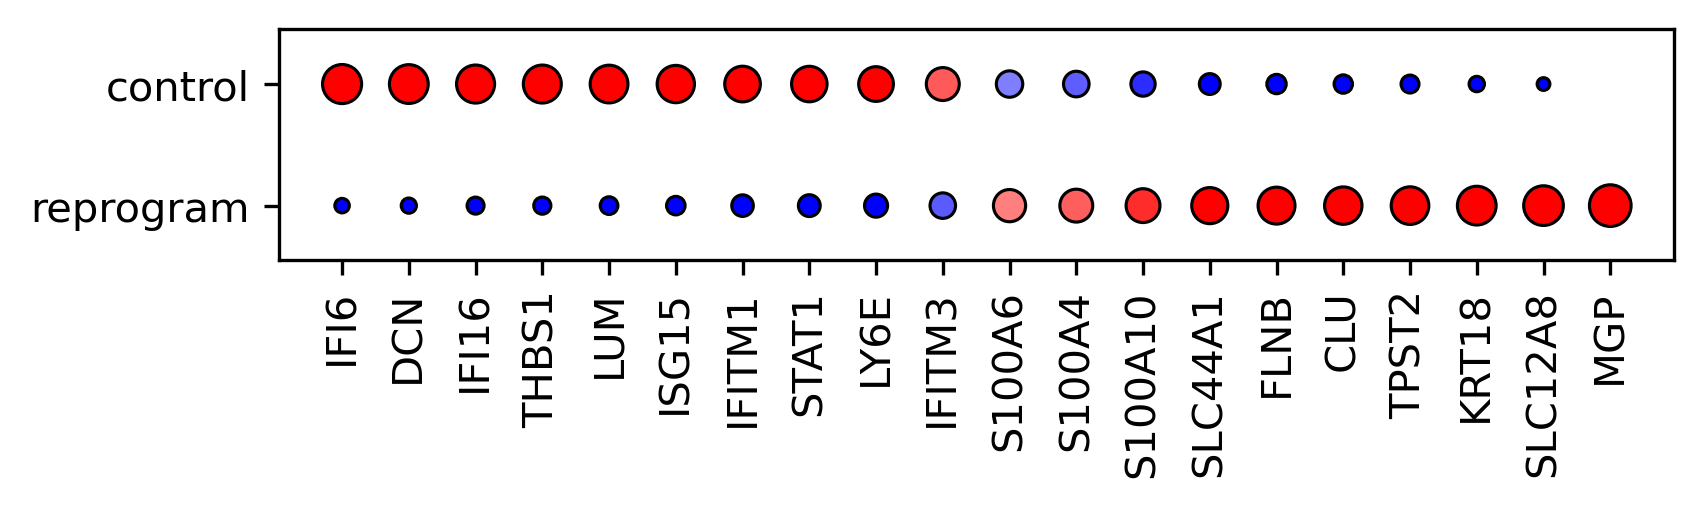

In [49]:
# selected by score
top_n_genes = 10
pct_nz_group = 0.1

gene_selection_col = 'scores'

groups = ['reprogram', 'control']
groups.reverse()

# filter out genes only expressed in a few cells, robust DEG
gdf = deg1[deg1['pct_nz_group'] > pct_nz_group].copy()

# sort by logfc and select top de genes per group
gdf = gdf.sort_values(by=['group', gene_selection_col], ascending=[True, False])
gdf = gdf.groupby('group').head(top_n_genes)

deg_genes = gdf['names'].unique()

# now filter the full frame for these genes
pdf = deg1[deg1['names'].isin(deg_genes)].copy()

pdf['label'] = pdf['group'].map({
    "control" : "control",
    "reprogramming" : "reprogram",
})
pdf = pdf.sort_values(by=['group', 'logfoldchanges'], ascending=[True, False])
gene_order = pdf['names'].unique()

pdf['names'] = pd.Categorical(pdf['names'], categories=gene_order, ordered=True)
pdf['label'] = pd.Categorical(pdf['label'], categories=groups, ordered=True)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 1

sns.scatterplot(
    data=pdf,
    x='names',
    y='label',
    hue='logfoldchanges',
    size='logfoldchanges',
    sizes=(0, 100),
    ec='k',
    lw=0.75,
    hue_norm=(-3, 3),
    legend=False,
    palette='bwr',
)

plt.margins(y=0.45)
plt.ylabel("")
plt.xlabel("")

ax = plt.gca()
y_labels = ax.get_yticklabels()
y_ticks = ax.get_yticks()
ax.tick_params(axis='x', rotation=90)
ax.set_yticks(y_ticks, y_labels)#, rotation=90, va='center')

plt.show()

# DGE control vs reprogram clusters

In [50]:
mapping = {
    'R1': 'R1',
    'R2': 'R2',
    'R3': 'R3',
    'C4': 'control',
    'C5': 'control',
}

adata.obs['group_clean'] = adata.obs['cluster_clean'].map(mapping)
adata.obs['group'] = adata.obs['cluster'].map(mapping) # with spike-in controls

sc.tl.rank_genes_groups(
    adata, 
    groupby='group',
    reference='control',
    method='wilcoxon',
    layer='log_norm',
    use_raw=False,
    pts=True,
    key_added='cluster_vs_control',
)

sc.tl.rank_genes_groups(
    adata, 
    groupby='group_clean',
    reference='control',
    method='wilcoxon',
    layer='log_norm',
    use_raw=False,
    pts=True,
    key_added='cluster_vs_control_clean',
)

ranking genes


... storing 'group' as categorical
... storing 'group_clean' as categorical


    finished (0:01:05)
ranking genes
    finished (0:00:53)


In [51]:
deg2 = sc.get.rank_genes_groups_df(
    adata, 
    group=None,
    key='cluster_vs_control_clean',
    pval_cutoff=0.05,
)
print(f"Initial n genes: {deg2['names'].nunique()}")

# merge with gtf file
deg2 = pd.merge(deg2, gtf, how='left', on='names')
print(f"After merging w GTF: {deg2['names'].nunique()}")

# remove ENSG and MT- genes
deg2 = deg2[~deg2['names'].str.startswith(('ENSG', 'MT-', 'RP'))]

# filter for protein-coding
deg2 = deg2[deg2['gene_type'] == 'protein_coding']

print(f"Protein-coding n genes: {deg2['names'].nunique()}")
deg2.head()

Initial n genes: 12272
After merging w GTF: 12272
Protein-coding n genes: 10329


,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,gene_type
0,R1,MGP,62.741127,7.860793,0.0,0.0,0.938066,protein_coding
1,R1,FTL,59.232521,1.782623,0.0,0.0,0.996475,protein_coding
2,R1,S100A6,58.273834,1.379020,0.0,0.0,1.000000,protein_coding
3,R1,KRT18,57.609814,5.086371,0.0,0.0,0.909366,protein_coding
4,R1,CLU,56.495922,4.179566,0.0,0.0,0.924975,protein_coding


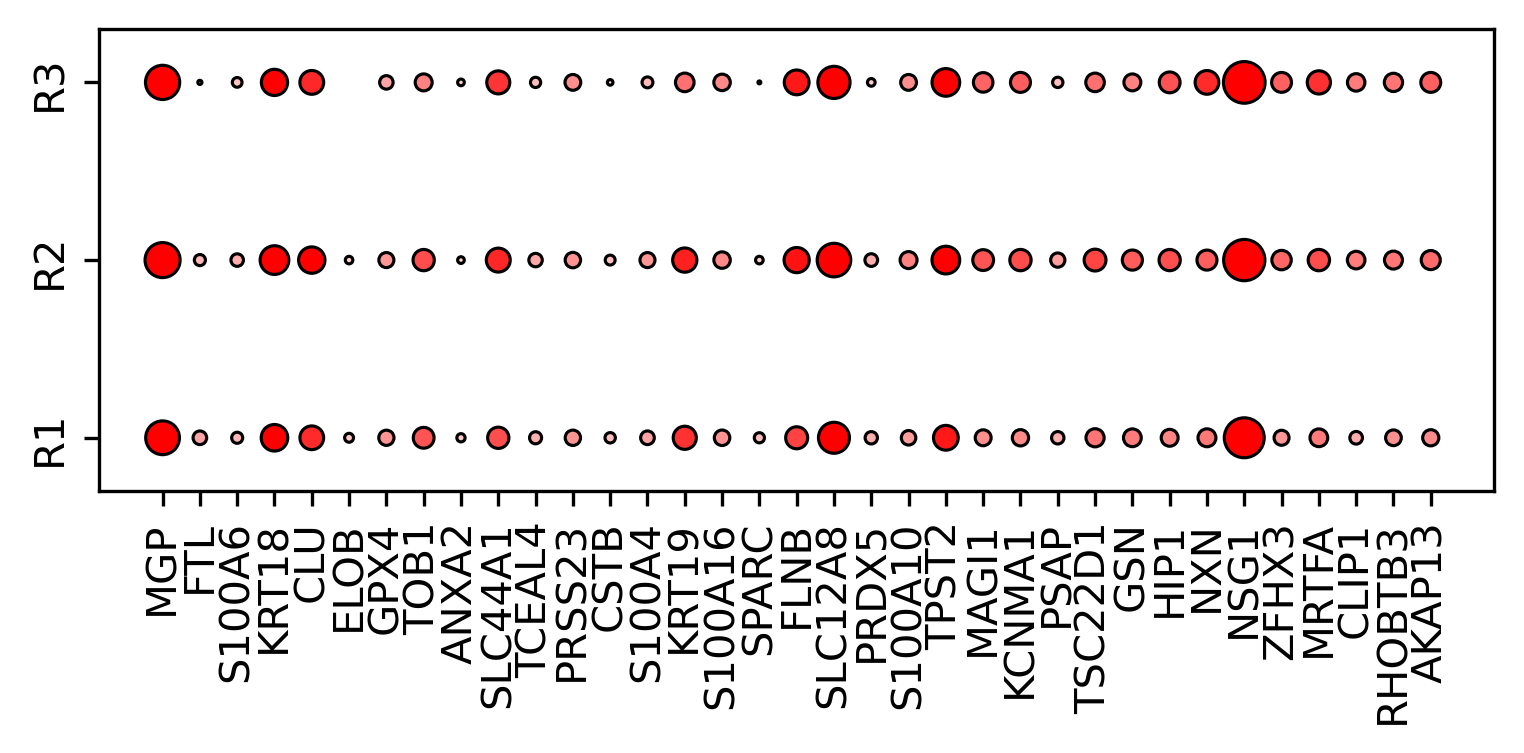

In [55]:
top_n_genes = 20
pct_nz_group = 0.3

select_col = 'scores'

groups = ['R1', 'R2', 'R3']
groups.reverse()

# filter out genes only expressed in a few cells, robust DEG
gdf = deg2[deg2['pct_nz_group'] > pct_nz_group].copy()

# sort by logfc and select top de genes per group
gdf = gdf.sort_values(by=['group', select_col], ascending=[True, False])
gdf = gdf.groupby('group').head(top_n_genes)

deg_genes = gdf['names'].unique()

# now filter the full frame for these genes
plot_df = deg2[deg2['names'].isin(deg_genes)].copy()

plot_df['label'] = plot_df['group'].apply(lambda x: x.replace("_", " "))
plot_df = plot_df.sort_values(by=['group', 'logfoldchanges'], ascending=[True, False])

plot_df['names'] = pd.Categorical(plot_df['names'], categories=deg_genes, ordered=True)
plot_df['label'] = pd.Categorical(plot_df['label'], categories=groups, ordered=True)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 2

sns.scatterplot(
    data=plot_df,
    x='names',
    y='label',
    hue='logfoldchanges',
    size='logfoldchanges',
    sizes=(0, 100),
    ec='k',
    lw=0.75,
    hue_norm=(-5, 5),
    legend=False,
    palette='bwr',
)

plt.margins(y=0.15)
plt.ylabel("")
plt.xlabel("")

ax = plt.gca()
y_labels = ax.get_yticklabels()
y_ticks = ax.get_yticks()
ax.tick_params(axis='x', rotation=90)
ax.set_yticks(y_ticks, y_labels, rotation=90, va='center')

plt.show()

In [56]:
deg2.head()

,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,gene_type
0,R1,MGP,62.741127,7.860793,0.0,0.0,0.938066,protein_coding
1,R1,FTL,59.232521,1.782623,0.0,0.0,0.996475,protein_coding
2,R1,S100A6,58.273834,1.379020,0.0,0.0,1.000000,protein_coding
3,R1,KRT18,57.609814,5.086371,0.0,0.0,0.909366,protein_coding
4,R1,CLU,56.495922,4.179566,0.0,0.0,0.924975,protein_coding


In [70]:
pd.set_option('display.max_colwidth', None)

database = 'celltypes'
# database = 'Tabula_Sapiens'
# database = "GO_Biological_Process_2025"
# database="KEGG_2021_Human"
# database='MSigDB_Hallmark_2020' 
database="Reactome_Pathways_2024"
# database = "CellMarker_2024"

n_query = 200

direction = 'up'
sort_col = 'scores'

groups = ['R1', 'R2', 'R3']

for group in groups:
    print(f"{group}:")
    tmp = deg2[deg2['group'] == group]
    
    if direction == 'up':
        tmp = tmp[tmp['logfoldchanges'] > 0]
        tmp = tmp.sort_values(by=sort_col, ascending=False) 
    else:
        tmp = tmp[tmp['logfoldchanges'] > 0]
        tmp = tmp.sort_values(by=sort_col, ascending=True)
        
    gene_list = tmp['names'].head(n_query).unique()

    edf = gget.enrichr(
        gene_list,
        database=database,
        save=False,
    )
    
    if database == 'CellMarker_2024':
        edf = edf[~edf['path_name'].str.endswith('Mouse')]
    
    display(edf[['path_name', 'overlapping_genes', 'adj_p_val']].head(15))
    print("=" * 100 + "\n")

14:26:13 - INFO - Performing Enrichr analysis using database Reactome_Pathways_2024.
2025-12-09 14:26:13 | [INFO] Performing Enrichr analysis using database Reactome_Pathways_2024.


R1:


,path_name,overlapping_genes,adj_p_val
0,Cellular Responses to Stimuli,"[TXN, PRDX2, CAPNS1, PPP2R1A, PRDX1, CREB3L1, ELOB, IGFBP7, FNIP1, ATP6V1F, ABCC3, ATP6V1G1, G6PD, ATP6V0E1, ANXA2, NDUFA4, TXNRD1, COX6C, ATOX1, PTK2, SEM1, H2AJ, COX7A2L, CAPZA1, GNAS, BLVRB, CRYAB, FKBP5, LAMTOR5]",0.000015
1,Innate Immune System,"[CSTB, CDA, GRN, BRI3, CD81, ARPC1B, BRK1, A1BG, TXN, CLU, PPP2R1A, PSAP, TIMP2, PRSS3, ATP6V1F, VAT1, ATP6V1G1, GSN, ATP6V0E1, ANXA2, JUP, NME2, ATOX1, PTK2, APRT, SERPINB6, SEM1, CRISPLD2, CAPZA1, CYSTM1, CFB, FTL]",0.000053
2,TP53 Regulates Metabolic Genes,"[PRDX2, G6PD, COX7A2L, NDUFA4, PRDX1, TXNRD1, TXN, COX6C, LAMTOR5]",0.000053
3,Cellular Response to Chemical Stress,"[ABCC3, SEM1, PRDX2, G6PD, COX7A2L, NDUFA4, PRDX1, TXNRD1, BLVRB, TXN, COX6C, ATOX1]",0.000191
4,Cellular Responses to Stress,"[ABCC3, ATP6V1G1, G6PD, ATP6V0E1, NDUFA4, TXNRD1, TXN, COX6C, ATOX1, SEM1, PRDX2, H2AJ, COX7A2L, PRDX1, CAPZA1, CREB3L1, BLVRB, ELOB, IGFBP7, FNIP1, CRYAB, FKBP5, LAMTOR5, ATP6V1F]",0.000199
5,Neutrophil Degranulation,"[VAT1, CSTB, CDA, GRN, GSN, ANXA2, JUP, BRI3, NME2, A1BG, APRT, SERPINB6, CRISPLD2, PSAP, TIMP2, CYSTM1, PRSS3, FTL]",0.000216
6,Respiratory Electron Transport,"[COX7A2L, NDUFA4, NDUFS5, NDUFB2, NDUFA1, COX14, UQCR11, UQCR10, COX6C, UQCRH]",0.000512
7,Dissolution of Fibrin Clot,"[ANXA2, SERPINE1, SERPINB6, S100A10]",0.000655
8,Aerobic Respiration and Respiratory Electron Transport,"[COX7A2L, NDUFA4, NDUFS5, NDUFB2, NDUFA1, UQCR11, COX14, UQCR10, COX6C, ATP5F1E, UQCRH, ATP5MC1]",0.001146
9,Detoxification of Reactive Oxygen Species,"[PRDX2, PRDX1, TXNRD1, TXN, ATOX1]",0.002257


14:26:13 - INFO - Performing Enrichr analysis using database Reactome_Pathways_2024.
2025-12-09 14:26:13 | [INFO] Performing Enrichr analysis using database Reactome_Pathways_2024.



R2:


,path_name,overlapping_genes,adj_p_val
0,Dissolution of Fibrin Clot,"[ANXA2, SERPINE1, SERPINB6, S100A10]",0.004183
1,"Signaling by Rho GTPases, Miro GTPases and RHOBTB3","[CENPT, DOCK5, KDM4C, JUP, RHOBTB3, MRTFA, BRK1, PRKCA, RASAL2, YWHAZ, PTK2, ARHGAP12, TIAM2, AKAP13, ARHGAP10, FGD4, CLIP1, ARHGEF3, NHS]",0.020977
2,Signaling by Rho GTPases,"[CENPT, DOCK5, KDM4C, JUP, MRTFA, BRK1, PRKCA, RASAL2, YWHAZ, PTK2, ARHGAP12, TIAM2, AKAP13, ARHGAP10, FGD4, CLIP1, ARHGEF3, NHS]",0.032042
3,Signaling by Receptor Tyrosine Kinases,"[SPARC, JUP, PXN, LAMA3, BRK1, PTPRJ, PRKCA, PTK2, EGFR, FER, ITCH, COL5A1, SGK1, EPS15, AP2M1]",0.054662
4,Netrin-1 Signaling,"[ABLIM1, SLIT3, UNC5C, PTK2]",0.108825
5,Axon Guidance,"[UNC5C, PRKCA, EFNA5, PTK2, EGFR, ENAH, DLG1, ABLIM1, COL5A1, ELOB, SLIT3, PABPC1, CD24, AP2M1]",0.108825
6,Signaling by MET,"[COL5A1, LAMA3, PTPRJ, EPS15, PTK2]",0.108825
7,Nervous System Development,"[UNC5C, PRKCA, EFNA5, PTK2, EGFR, ENAH, DLG1, ABLIM1, COL5A1, ELOB, SLIT3, PABPC1, CD24, AP2M1]",0.137116
8,Response to Elevated Platelet Cytosolic Ca2+,"[SPARC, SERPINE1, PSAP, PRKCA, CYRIB, CLU]",0.137116
9,NRAGE Signals Death Through JNK,"[TIAM2, AKAP13, FGD4, ARHGEF3]",0.137116


14:26:14 - INFO - Performing Enrichr analysis using database Reactome_Pathways_2024.
2025-12-09 14:26:14 | [INFO] Performing Enrichr analysis using database Reactome_Pathways_2024.



R3:


,path_name,overlapping_genes,adj_p_val
0,"Signaling by Rho GTPases, Miro GTPases and RHOBTB3","[CENPT, DOCK5, RHOBTB3, MRTFA, PRKCA, RASAL2, ARHGAP26, YWHAZ, CENPA, PTK2, CIT, ARHGAP12, TIAM2, AKAP13, ARHGAP10, FGD4, CLIP1, TUBB6, TUBB3, PRC1, ABL1, NHS, NUP98]",0.000335
1,Signaling by Rho GTPases,"[CENPT, DOCK5, MRTFA, PRKCA, RASAL2, ARHGAP26, YWHAZ, CENPA, PTK2, CIT, ARHGAP12, TIAM2, AKAP13, ARHGAP10, FGD4, CLIP1, TUBB6, TUBB3, PRC1, ABL1, NHS, NUP98]",0.000430
2,Hemostasis,"[DOCK5, ABCC4, ANXA2, SERPINE1, JMJD1C, PRKCA, KIF11, CYRIB, CLU, YWHAZ, PTK2, SERPINB6, RAD51B, TUBB6, TUBB3, CAPZA1, KCNMA1, PSAP, GNAS, ABL1, RCOR1, S100A10]",0.000657
3,Dissolution of Fibrin Clot,"[ANXA2, SERPINE1, SERPINB6, S100A10]",0.001009
4,Signal Transduction,"[GPSM2, DOCK5, SERPINE1, RBPJ, AKAP13, TUBB6, ADGRE5, TUBB3, SCMH1, AKT3, PIP4K2A, MRTFA, PRKCA, YWHAZ, CIT, TIAM2, ARHGAP10, CLIP1, TBL1XR1, NUP98, SGK1, FKBP5, PHLPP1, RHOBTB3, LTBP2, RASAL2, CENPA, EGFR, ARHGAP12, FGD4, PSAP, ABL1, NHS, EPS15, CD55, CENPT, WWOX, SMAD3, ARHGAP26, PTK2, DLG1, FER, STAG1, ITCH, COL5A1, PRC1, GNAS, NF1, RCOR1]",0.001009
5,RHO GTPase Effectors,"[CENPT, MRTFA, PRKCA, YWHAZ, CENPA, PTK2, CIT, CLIP1, TUBB6, TUBB3, PRC1, ABL1, NUP98]",0.001009
6,Factors Involved in Megakaryocyte Development and Platelet Production,"[RAD51B, DOCK5, TUBB6, TUBB3, CAPZA1, ABL1, JMJD1C, KIF11, RCOR1]",0.003429
7,Resolution of Sister Chromatid Cohesion,"[CENPT, TUBB6, CLIP1, STAG1, TUBB3, NUP98, CENPA]",0.026924
8,Axon Guidance,"[MYO10, PRKCA, UNC5C, EFNA5, PTK2, EGFR, ENAH, DLG1, ABLIM1, TUBB6, COL5A1, TUBB3, ABL1, ELOB, PABPC1]",0.031999
9,RHO GTPases Activate Formins,"[CENPT, TUBB6, CLIP1, TUBB3, MRTFA, NUP98, CENPA]",0.039038


In [68]:
edf[edf['path_name'].str.contains('ematopoietic')].head()

,rank,path_name,p_val,z_score,combined_score,overlapping_genes,adj_p_val,database
317,318,Hematopoietic Stem Cell Undefined Human,0.310783,2.758794,3.224097,[ZBTB16],0.363392,CellMarker_2024
324,325,Hematopoietic Stem Cell Blood Human,0.331292,2.546193,2.812923,[ZBTB16],0.377895,CellMarker_2024
348,349,Hematopoietic Stem Cell Bone Marrow Human,0.464244,1.626081,1.247765,[ZBTB16],0.496169,CellMarker_2024
